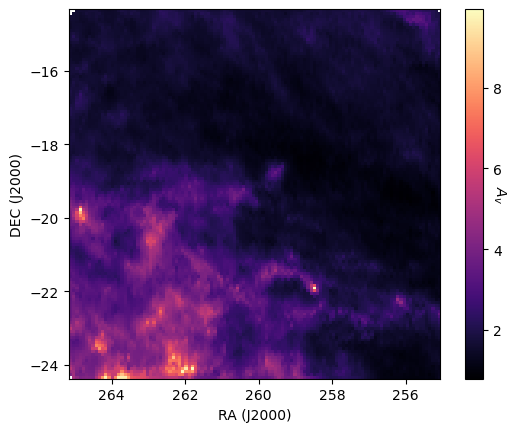

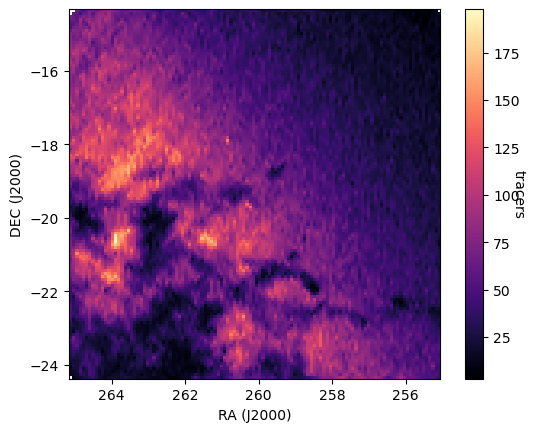

In [1]:
import os
import numpy as np
import healpy as hpp
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

Av="$A_{v}$"
trac="tracers"
filename='I_355_tgextmap.npz'
ext_g=np.load(filename)
h_id=ext_g['HPId']
a0=ext_g['A0']
numtr=ext_g['Ntracers']

ra=260.10740722
dec=-19.3523078
level=9
radius=5
num_points=800 #points for ra and dec
step=5  #step from center ra and dec for coordinate grid

def plott(cd,arr,name):
    ra=np.unique(cd.ra.value)
    dec=np.unique(cd.dec.value)
    X,Y= np.meshgrid(ra,dec)
    zi = griddata((cd.ra.value,cd.dec.value),np.array(arr), (X, Y), method='linear')
    plt.imshow(zi, cmap=plt.cm.magma, interpolation='none', extent=[X.min(), X.max(), Y.min(), Y.max()],origin='lower')
    cbar=plt.colorbar()
    cbar.set_label(name, rotation=270,fontsize=10)
    plt.xlabel('RA (J2000)')
    plt.ylabel('DEC (J2000)')
    plt.gca().invert_xaxis()
    plt.show()
    plt.close()
    

def healpix_(ra,dec,step,radius,level,h_id,a0,numtr,num_points):
    ra_range=(ra-step,ra+step)
    dec_range=(dec-step,dec+step)
    from astropy_healpix import HEALPix as hp
    ra_values = np.linspace(ra_range[0], ra_range[1], num_points) * u.deg
    dec_values = np.linspace(dec_range[0], dec_range[1], num_points) * u.deg
    grid_ra, grid_dec = np.meshgrid(ra_values, dec_values)
    grid_ra_values = grid_ra.flatten()
    grid_dec_values = grid_dec.flatten()
    coords = SkyCoord(ra=grid_ra_values, dec=grid_dec_values, frame='icrs')
    hp = hp(nside=2**level, order='nested', frame='icrs')
    healp_polyg=hp.skycoord_to_healpix(coords)
    common = h_id[np.isin(h_id,healp_polyg)]
    ext=a0[np.isin(h_id,healp_polyg)]
    tracers=numtr[np.isin(h_id,healp_polyg)]
    cd=hp.healpix_to_skycoord(common)
    plott(cd,ext,Av)
    plott(cd,tracers,trac)
    return grid_ra_values,grid_dec_values

r,d=healpix_(ra,dec,step,radius,level,h_id,a0,numtr,num_points)

In [ ]:
#all polygon and search by grid in gaia how many rows is in polygon
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier
coord = SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')
gair = Vizier(catalog='I/355/gaiadr3',columns=['RAJ2000','DEJ2000'])
gair.ROW_LIMIT = -1
result_gr = gair.query_region(coord,5*u.deg,5*u.deg)
gair_table = result_gr[0]
print(len(gair_table))

In [ ]:
np.savetxt('/home/anastasia/Documents/AUTUMN2023/Gaia1.txt',gair_table,delimiter='	',fmt='%s')

In [ ]:
import numpy as np
from astropy import coordinates as coord
from astropy import units as u
from scipy.sparse import lil_matrix
'''
grid_ra_values = r
grid_dec_values = d

table_ra_values = gair_table['RAJ2000']
table_dec_values = gair_table['DEJ2000']

grid_coords = coord.SkyCoord(grid_ra_values, grid_dec_values, unit=(u.degree, u.degree), frame='icrs')
table_coords = coord.SkyCoord(table_ra_values, table_dec_values, unit=(u.degree, u.degree), frame='icrs')

box_width = 0.01 * u.degree
box_height = 0.01 * u.degree

grid_ra_float = np.array(grid_coords.ra.deg)
grid_dec_float = np.array(grid_coords.dec.deg)

num_boxes_ra = int((grid_coords.ra.max() - grid_coords.ra.min()) / box_width) + 1
num_boxes_dec = int((grid_coords.dec.max() - grid_coords.dec.min()) / box_height) + 1

box_indices_ra = np.floor((table_coords.ra - grid_coords.ra.min()) / box_width).astype(int)
box_indices_dec = np.floor((table_coords.dec - grid_coords.dec.min()) / box_height).astype(int)

valid_indices = (box_indices_ra >= 0) & (box_indices_ra < num_boxes_ra) & (box_indices_dec >= 0) & (box_indices_dec < num_boxes_dec)
box_indices_ra = box_indices_ra[valid_indices]
box_indices_dec = box_indices_dec[valid_indices]


num_rows_in_pixel = lil_matrix((num_boxes_dec, num_boxes_ra), dtype=int)


for i, j in zip(box_indices_dec, box_indices_ra):
    num_rows_in_pixel[i, j] += 1


scalar_sparse = lil_matrix((1,), dtype=int)


num_rows_in_pixel += scalar_sparse


array_stars = num_rows_in_pixel.toarray()

print(len(array_stars))
'''

import numpy as np
from numba import jit
from astropy import coordinates as coord
from astropy import units as u
from scipy.sparse import coo_matrix

@jit
def compute_num_rows_in_pixel(grid_ra_values, grid_dec_values, table_ra_values, table_dec_values, box_width, box_height):
    grid_coords = coord.SkyCoord(grid_ra_values, grid_dec_values, unit=(u.degree, u.degree), frame='icrs')
    table_coords = coord.SkyCoord(table_ra_values, table_dec_values, unit=(u.degree, u.degree), frame='icrs')

    grid_ra_float = np.array(grid_coords.ra.deg)
    grid_dec_float = np.array(grid_coords.dec.deg)

    num_rows_in_pixel = coo_matrix((len(grid_ra_float), len(grid_dec_float)), dtype=np.int64)

    for box_center_ra, box_center_dec in zip(grid_ra_float.flatten(), grid_dec_float.flatten()):
        box_ra_min = box_center_ra - (box_width / 2)
        box_ra_max = box_center_ra + (box_width / 2)
        box_dec_min = box_center_dec - (box_height / 2)
        box_dec_max = box_center_dec + (box_height / 2)

        rows_in_pixel = np.where(
            (table_coords.ra.deg >= box_ra_min) & (table_coords.ra.deg <= box_ra_max) &
            (table_coords.dec.deg >= box_dec_min) & (table_coords.dec.deg <= box_dec_max)
        )[0]

        i, j = int(np.round((box_center_ra - grid_ra_float.min()) / box_width)), int(np.round((box_center_dec - grid_dec_float.min()) / box_height))

        for row in rows_in_pixel:
            num_rows_in_pixel[i, j] += 1

    return num_rows_in_pixel

grid_ra_values = np.ma.getdata(r)
grid_dec_values = np.ma.getdata(d)

table_ra_values = np.ma.getdata(gair_table['RAJ2000'])
table_dec_values = np.ma.getdata(gair_table['DEJ2000'])

box_width = 0.01
box_height = 0.01

result = compute_num_rows_in_pixel(grid_ra_values, grid_dec_values, table_ra_values, table_dec_values, box_width, box_height)
print('ok')

In [ ]:
from numba import jit
from numba import types
from numba.types import int64

grid_ra_values = r
grid_dec_values = d

table_ra_values = gair_table['RAJ2000']
table_dec_values = gair_table['DEJ2000']
from numba.sparse import lil_matrix

@jit(nopython=True)
def compute_num_rows_in_pixel(grid_ra_values, grid_dec_values, table_ra_values, table_dec_values, box_width, box_height):
    grid_ra_float = np.array(grid_ra_values)
    grid_dec_float = np.array(grid_dec_values)
    num_rows_in_pixel = lil_matrix((len(grid_ra_float), len(grid_dec_float)), dtype=types.uint32)

    for box_center_ra, box_center_dec in zip(grid_ra_float.flatten(), grid_dec_float.flatten()):
        box_ra_min = box_center_ra - (box_width / 2)
        box_ra_max = box_center_ra + (box_width / 2)
        box_dec_min = box_center_dec - (box_height / 2)
        box_dec_max = box_center_dec + (box_height / 2)

        rows_in_pixel = np.where(
            (table_ra_values >= box_ra_min) & (table_ra_values <= box_ra_max) &
            (table_dec_values >= box_dec_min) & (table_dec_values <= box_dec_max)
        )[0]
        i, j = int(np.round((box_center_ra - grid_ra_float.min()) / box_width)), int(np.round((box_center_dec - grid_dec_float.min()) / box_height))

        num_rows_in_pixel[i, j] = len(rows_in_pixel)

    return num_rows_in_pixel.toarray()

grid_coords = coord.SkyCoord(grid_ra_values, grid_dec_values, unit=(u.degree, u.degree), frame='icrs')
table_coords = coord.SkyCoord(table_ra_values, table_dec_values, unit=(u.degree, u.degree), frame='icrs')

box_width = 0.01
box_height = 0.01

result_array = compute_num_rows_in_pixel(grid_coords.ra.deg, grid_coords.dec.deg, table_coords.ra.deg, table_coords.dec.deg, box_width, box_height)

print(len(result_array))

In [ ]:
from numba import jit
grid_ra_values = r
grid_dec_values = d

table_ra_values = gair_table['RAJ2000']
table_dec_values = gair_table['DEJ2000']

@jit(nopython=True)
def compute_num_rows_in_pixel(grid_ra_values, grid_dec_values, table_ra_values, table_dec_values, box_width, box_height, result_array):
    for i in range(len(grid_ra_values)):
        for j in range(len(grid_dec_values)):
            box_center_ra = grid_ra_values[i]
            box_center_dec = grid_dec_values[j]
            box_ra_min = box_center_ra - (box_width / 2)
            box_ra_max = box_center_ra + (box_width / 2)
            box_dec_min = box_center_dec - (box_height / 2)
            box_dec_max = box_center_dec + (box_height / 2)

            rows_in_pixel = np.where(
                (table_ra_values >= box_ra_min) & (table_ra_values <= box_ra_max) &
                (table_dec_values >= box_dec_min) & (table_dec_values <= box_dec_max)
            )[0]

            result_array[i, j] = len(rows_in_pixel)

grid_coords = coord.SkyCoord(grid_ra_values, grid_dec_values, unit=(u.degree, u.degree), frame='icrs')
table_coords = coord.SkyCoord(table_ra_values, table_dec_values, unit=(u.degree, u.degree), frame='icrs')

box_width = 0.01
box_height = 0.01

result_array = np.memmap('result_array.dat', dtype=np.uint32, mode='w+', shape=(len(grid_coords.ra.deg), len(grid_coords.dec.deg)))

chunk_size = 1000

for i in range(0, len(grid_coords.ra.deg), chunk_size):
    for j in range(0, len(grid_coords.dec.deg), chunk_size):
        grid_ra_chunk = grid_coords.ra.deg[i:i+chunk_size]
        grid_dec_chunk = grid_coords.dec.deg[j:j+chunk_size]
        result_array_chunk = np.zeros((len(grid_ra_chunk), len(grid_dec_chunk)), dtype=np.uint32)
        compute_num_rows_in_pixel(grid_ra_chunk, grid_dec_chunk, table_coords.ra.deg, table_coords.dec.deg, box_width, box_height, result_array_chunk)
        result_array[i:i+chunk_size, j:j+chunk_size] = result_array_chunk


array_stars = result_array
print(len(result_array))
